In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from scipy import stats
import cftime

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rcParams #For changing text properties
import cmocean #A package with beautiful colormaps
from cartopy import crs as ccrs #Useful for plotting maps
import cartopy.util #Requires separate import
from cartopy.util import add_cyclic_point
import cartopy.feature as cf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.path as mpath
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
import tensorflow as tf    
#tf.compat.v1.disable_v2_behavior() # <-- HERE !

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Activation, Reshape, Flatten, LSTM, Dense, Dropout, Embedding, Bidirectional, GRU
from tensorflow.keras import Sequential
from tensorflow.keras import initializers, regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import constraints
from tensorflow.keras.layers import Layer, InputSpec

2025-04-04 19:10:34.819100: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-04 19:10:34.854172: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Before building a machine learning (ML) model, we need to formulate the question clearly. What do we want to study or predict? Will we predict the actual values or the category of a variable? Once we know the goal of the study, we next think about what the predictors (input to the ML model) and the predictand (output of the ML model) will be. 

### In this lab session, let's study one of the simplest and well-used examples: predict ENSO.

### Here we are training a classifier to predict whether an El Niño or La Niña event is occurring. The input is a map of global sea surface temperature (SST), and the output is a binary classification of either 1=El Niño or 0=La Niña.

### Load in the data from the netcdf. This is ERSSTv5 which has been deseasoned, linearly detrended, and has a 5 month lookback running mean applied. This data is from Dr. Elizabeth Barnes.

In [17]:
# Read data
DIR = '/nfs/spare11/env315/data/'
datafile = DIR+'ERSSTv5_deseasoneddetrended_5monthrunningmean_1950-2021.nc'
data = xr.open_mfdataset(datafile).compute()
sst = data.sst
sst

<xarray.DataArray 'sst' (time: 859, lat: 89, lon: 180)> Size: 110MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time     (time) object 7kB 1950-06-01 00:00:00 ... 2021-12-15 00:00:00
  * lat      (lat) float64 712B -88.0 -86.0 -84.0 -82.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0

### Before building a good ML model, we need to understand the data (get a feeling of the features) and preprocess the data to prepare the input and output for the ML model.

### For example, we can plot the SST data to get a feeling for it.
### Let's plot the SST of January 2021.

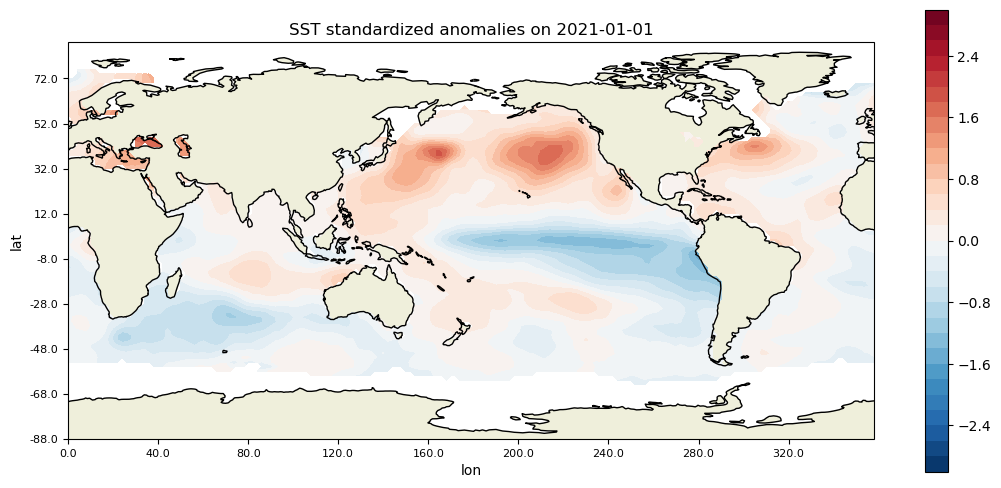

In [18]:
sst_1 = sst.sel(time=cftime.Datetime360Day(2021, 1, 15))
figure = plt.figure(figsize=(13,6))
ax = figure.add_subplot(1,1,1,projection=ccrs.PlateCarree(central_longitude=180))
hm = ax.contourf(sst.lon.values,sst.lat.values,sst_1.values,cmap='RdBu_r',levels=np.arange(-3,3.2,0.2),transform=ccrs.PlateCarree())
plt.title('SST standardized anomalies on 2021-01-01')

long = data.lon.values[0:180:20]
latg = data.lat.values[0:91:10]
ax.set_xticks(long, crs=ccrs.PlateCarree())
ax.set_yticks(latg, crs=ccrs.PlateCarree())
ax.set_xticklabels(long, fontsize=8)
ax.set_yticklabels(latg, fontsize=8)
ax.set_ylabel('lat', fontsize=10)
ax.set_xlabel('lon', fontsize=10)

ax.add_feature(cf.LAND)
ax.coastlines()

# define your own colorbar feature
cbar = plt.colorbar(hm, orientation='vertical',pad=0.05)
cbar.ax.tick_params(labelsize=10) 

## Calculate Nino 3.4 index from SST data and plot the time series of the index

In [19]:
sst_s = sst.sel(lat=slice(-5,5),lon=slice(-170+360,-120+360))
nino34 = sst_s.mean(dim='lat').mean(dim='lon')
nino34

<xarray.DataArray 'sst' (time: 859)> Size: 7kB
array([-1.25487574e+00, -1.08986989e+00, -9.35813070e-01, -8.41517700e-01,
       -7.46620137e-01, -6.13831588e-01, -6.14911157e-01, -6.87904944e-01,
       -7.65514303e-01, -7.84147307e-01, -6.62970277e-01, -4.54115402e-01,
       -1.77333983e-01,  1.00550344e-01,  3.85547213e-01,  5.00353643e-01,
        6.32019048e-01,  7.20657086e-01,  8.25315676e-01,  8.14757611e-01,
        7.94071429e-01,  6.83326477e-01,  5.56921294e-01,  4.51376693e-01,
        3.76520489e-01,  2.60958674e-01,  1.27098998e-01,  4.33110357e-02,
       -4.17416927e-02, -1.14607846e-01, -1.67577427e-01, -1.06733223e-01,
        2.89313849e-02,  1.41403543e-01,  2.80397651e-01,  4.86602405e-01,
        6.50454395e-01,  7.09257697e-01,  7.05493075e-01,  6.71805125e-01,
        6.71121612e-01,  6.24383310e-01,  5.76394612e-01,  6.17239575e-01,
        6.73612332e-01,  6.62852141e-01,  5.46933638e-01,  2.84594653e-01,
        5.63063949e-02, -1.97960996e-01, -4.71622936e-01, -6.75714956e-01,
       -7.77138590e-01, -9.20231283e-01, -9.65310107e-01, -1.00917787e+00,
       -9.21705102e-01, -7.97644193e-01, -7.20967238e-01, -7.28813475e-01,
       -7.00098430e-01, -7.32389672e-01, -7.56607041e-01, -8.07782006e-01,
       -8.68188213e-01, -1.08274352e+00, -1.34089877e+00, -1.53018815e+00,
       -1.51481928e+00, -1.43236386e+00, -1.14497266e+00, -8.40883272e-01,
       -5.78631362e-01, -5.02424540e-01, -5.01211713e-01, -5.66096122e-01,
       -5.86698155e-01, -6.29594876e-01, -6.79577956e-01, -6.58479585e-01,
...
        5.91854237e-01,  7.41432730e-01,  9.61974012e-01,  1.25612582e+00,
        1.54041134e+00,  1.81873466e+00,  2.12052329e+00,  2.34787516e+00,
        2.46290684e+00,  2.46555603e+00,  2.31068222e+00,  1.95857694e+00,
        1.50779547e+00,  1.01083112e+00,  4.85584217e-01,  5.48492506e-02,
       -2.54865428e-01, -4.72898154e-01, -6.24337540e-01, -6.44086727e-01,
       -6.30447427e-01, -5.43174088e-01, -3.99532752e-01, -2.01409507e-01,
       -1.45103987e-02,  1.55997328e-01,  2.42208118e-01,  2.11671073e-01,
        6.93736006e-02, -1.23606107e-01, -3.87246130e-01, -6.51524319e-01,
       -8.29572756e-01, -9.07579677e-01, -9.62509243e-01, -8.63583662e-01,
       -6.86261730e-01, -4.60607795e-01, -2.58732006e-01, -7.08388724e-02,
        1.11721162e-01,  3.24634463e-01,  4.91474963e-01,  6.28204716e-01,
        7.23951898e-01,  7.63177332e-01,  7.33819186e-01,  6.83279450e-01,
        6.33810793e-01,  6.12539574e-01,  5.56986729e-01,  4.11312824e-01,
        2.78910818e-01,  2.56479071e-01,  2.66442021e-01,  2.86596668e-01,
        3.84156811e-01,  4.41670728e-01,  4.30235662e-01,  4.04405674e-01,
        2.62215406e-01,  9.27300142e-02, -2.32130206e-02, -2.29591664e-01,
       -4.83171662e-01, -6.86792652e-01, -9.07095047e-01, -1.09042237e+00,
       -1.18736176e+00, -1.23144401e+00, -1.15215372e+00, -1.00697349e+00,
       -8.53736502e-01, -6.92180949e-01, -5.52627342e-01, -4.92979489e-01,
       -4.75791015e-01, -5.81386238e-01, -7.19192098e-01])
Coordinates:
  * time     (time) object 7kB 1950-06-01 00:00:00 ... 2021-12-15 00:00:00

In [20]:
time_coord = nino34['time'].values

datetime_list = []
for cf_time in time_coord:
    # Attempt a direct conversion (might raise an error for invalid dates)
    dt_object = pd.Timestamp(cf_time.year, cf_time.month, cf_time.day,
                             cf_time.hour, cf_time.minute, cf_time.second)
    datetime_list.append(dt_object)
    
# Create a new coordinate or replace the existing one
nino34['time'] = ('time', np.array(datetime_list))
nino34['time'].attrs['calendar'] = 'standard' # Update calendar attribute
nino34

<xarray.DataArray 'sst' (time: 859)> Size: 7kB
array([-1.25487574e+00, -1.08986989e+00, -9.35813070e-01, -8.41517700e-01,
       -7.46620137e-01, -6.13831588e-01, -6.14911157e-01, -6.87904944e-01,
       -7.65514303e-01, -7.84147307e-01, -6.62970277e-01, -4.54115402e-01,
       -1.77333983e-01,  1.00550344e-01,  3.85547213e-01,  5.00353643e-01,
        6.32019048e-01,  7.20657086e-01,  8.25315676e-01,  8.14757611e-01,
        7.94071429e-01,  6.83326477e-01,  5.56921294e-01,  4.51376693e-01,
        3.76520489e-01,  2.60958674e-01,  1.27098998e-01,  4.33110357e-02,
       -4.17416927e-02, -1.14607846e-01, -1.67577427e-01, -1.06733223e-01,
        2.89313849e-02,  1.41403543e-01,  2.80397651e-01,  4.86602405e-01,
        6.50454395e-01,  7.09257697e-01,  7.05493075e-01,  6.71805125e-01,
        6.71121612e-01,  6.24383310e-01,  5.76394612e-01,  6.17239575e-01,
        6.73612332e-01,  6.62852141e-01,  5.46933638e-01,  2.84594653e-01,
        5.63063949e-02, -1.97960996e-01, -4.71622936e-01, -6.75714956e-01,
       -7.77138590e-01, -9.20231283e-01, -9.65310107e-01, -1.00917787e+00,
       -9.21705102e-01, -7.97644193e-01, -7.20967238e-01, -7.28813475e-01,
       -7.00098430e-01, -7.32389672e-01, -7.56607041e-01, -8.07782006e-01,
       -8.68188213e-01, -1.08274352e+00, -1.34089877e+00, -1.53018815e+00,
       -1.51481928e+00, -1.43236386e+00, -1.14497266e+00, -8.40883272e-01,
       -5.78631362e-01, -5.02424540e-01, -5.01211713e-01, -5.66096122e-01,
       -5.86698155e-01, -6.29594876e-01, -6.79577956e-01, -6.58479585e-01,
...
        5.91854237e-01,  7.41432730e-01,  9.61974012e-01,  1.25612582e+00,
        1.54041134e+00,  1.81873466e+00,  2.12052329e+00,  2.34787516e+00,
        2.46290684e+00,  2.46555603e+00,  2.31068222e+00,  1.95857694e+00,
        1.50779547e+00,  1.01083112e+00,  4.85584217e-01,  5.48492506e-02,
       -2.54865428e-01, -4.72898154e-01, -6.24337540e-01, -6.44086727e-01,
       -6.30447427e-01, -5.43174088e-01, -3.99532752e-01, -2.01409507e-01,
       -1.45103987e-02,  1.55997328e-01,  2.42208118e-01,  2.11671073e-01,
        6.93736006e-02, -1.23606107e-01, -3.87246130e-01, -6.51524319e-01,
       -8.29572756e-01, -9.07579677e-01, -9.62509243e-01, -8.63583662e-01,
       -6.86261730e-01, -4.60607795e-01, -2.58732006e-01, -7.08388724e-02,
        1.11721162e-01,  3.24634463e-01,  4.91474963e-01,  6.28204716e-01,
        7.23951898e-01,  7.63177332e-01,  7.33819186e-01,  6.83279450e-01,
        6.33810793e-01,  6.12539574e-01,  5.56986729e-01,  4.11312824e-01,
        2.78910818e-01,  2.56479071e-01,  2.66442021e-01,  2.86596668e-01,
        3.84156811e-01,  4.41670728e-01,  4.30235662e-01,  4.04405674e-01,
        2.62215406e-01,  9.27300142e-02, -2.32130206e-02, -2.29591664e-01,
       -4.83171662e-01, -6.86792652e-01, -9.07095047e-01, -1.09042237e+00,
       -1.18736176e+00, -1.23144401e+00, -1.15215372e+00, -1.00697349e+00,
       -8.53736502e-01, -6.92180949e-01, -5.52627342e-01, -4.92979489e-01,
       -4.75791015e-01, -5.81386238e-01, -7.19192098e-01])
Coordinates:
  * time     (time) datetime64[ns] 7kB 1950-06-01 1950-07-01 ... 2021-12-15

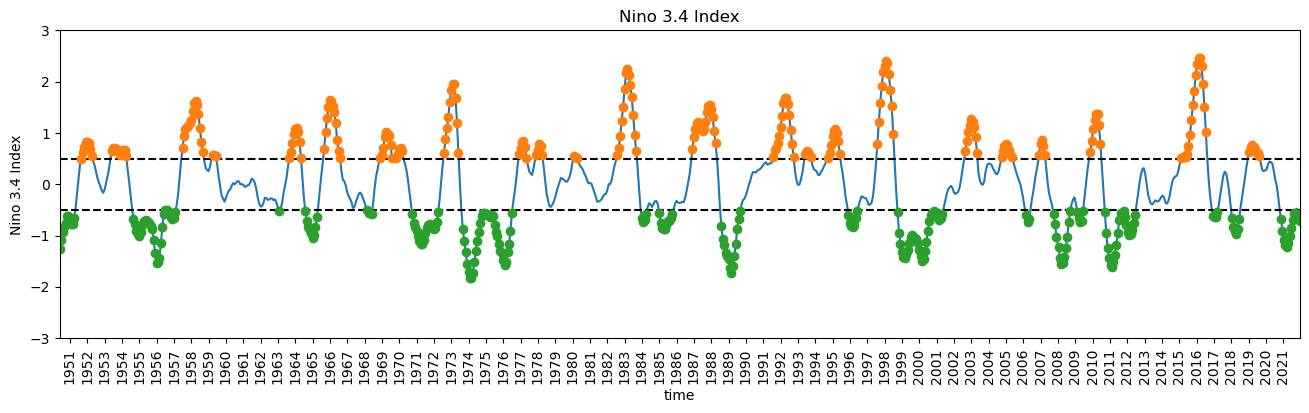

In [22]:
plt.figure(figsize=(16,4))
plt.plot(nino34.time.values,nino34)
plt.hlines(0.5,xmin=nino34.time.values.min(), xmax=nino34.time.values.max(),linestyle='dashed',color='k')
plt.hlines(-0.5,xmin=nino34.time.values.min(), xmax=nino34.time.values.max(),linestyle='dashed',color='k')
plt.xlim(nino34.time.values.min(), nino34.time.values.max())
plt.ylim(-3,3)
plt.xlabel("time")
plt.ylabel("Nino 3.4 Index")
plt.title("Nino 3.4 Index")
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=90);

tmp = np.copy(nino34)
tmp[np.where(nino34<0.5)] = 0+np.nan
plt.plot(nino34.time.values,tmp,'o')

tmp = np.copy(nino34)
tmp[np.where(nino34>-0.5)] = 0+np.nan
plt.plot(nino34.time.values,tmp,'o')

plt.show()

## Prepare output for the neural network model

### We define El Niño as nino34>0.5 and La Niña as nino34<-0.5.

### The output is a binary classification of either 1=El Niño or 0=La Niña.

In [28]:
nino34 = nino34.values
enso_event = nino34[(nino34>0.5) | (nino34<-0.5)]
enso_event[enso_event>0.5] = 1 
enso_event[enso_event<-0.5] = 0
nevent = len(enso_event)
# convert to format accepted by NN
enso_event = tf.keras.utils.to_categorical(enso_event) 
print('Number of events (sample size): ',nevent)
print('Shape of enso_event: ', enso_event.shape)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

## Prepare input for the neural network model

### We select SST corresponds to nino34<0.5 and nino34>-0.5. 

In [29]:
sst = np.asarray(sst)
nsize = sst.shape
sst_to_enso = sst[(nino34>0.5) | (nino34<-0.5),:,:]
print('Shape of sst_to_enso: ',sst_to_enso.shape)

# reshape (lat,lon) to (latxlon)
sst_to_enso = np.reshape(sst_to_enso,(nevent,nsize[1]*nsize[2]))
print('Shape of sst_to_enso after reshape: ',np.shape(sst_to_enso))

Shape of sst_to_enso:  (464, 89, 180)
Shape of sst_to_enso after reshape:  (464, 16020)


### Now we can see that the shape of input is (464,16020) and the shape of output is (464,). 464 is the sample size. Each sample in the input corresponds to each sample in the output. 

## Divide the sst input and nino3.4 output into training, validation and testing chunks.

### The first 70% of data is used for training, the remaining 15% of data is used for validation, and the last 15% of data is used for testing. 

In [30]:
ntrain = int(nevent*0.7)
nvalid = int((nevent-ntrain)*0.50)
ntest = nevent-ntrain-nvalid
sst_train = sst_to_enso[0:ntrain,:]
sst_val = sst_to_enso[ntrain:ntrain+nvalid,:]
sst_test = sst_to_enso[ntrain+nvalid:,:]
print('Shape of train input: ', sst_train.shape)
print('Shape of validation input: ', sst_val.shape)
print('Shape of test input: ', sst_test.shape)

enso_train = enso_event[0:ntrain,:]
enso_val = enso_event[ntrain:ntrain+nvalid,:]
enso_test = enso_event[ntrain+nvalid:,:]
print('Shape of train output: ', enso_train.shape)
print('Shape of validation output: ', enso_val.shape)
print('Shape of test output: ', enso_test.shape)

Shape of train input:  (324, 16020)
Shape of validation input:  (70, 16020)
Shape of test input:  (70, 16020)
Shape of train output:  (324, 2)
Shape of validation output:  (70, 2)
Shape of test output:  (70, 2)


In [31]:
# A final step before building and training a neural network mdoel
# Given that nans will cause errors in trainning, set all nans to zeros (they are learned to be ignored)
# standardized by the TRAINING STD
sst_std = np.std(sst_train,axis=0) 

sst_train = np.divide(sst_train,sst_std)
sst_train[np.isnan(sst_train)] = 0 
sst_val = np.divide(sst_val,sst_std)
sst_val[np.isnan(sst_val)] = 0
sst_test = np.divide(sst_test,sst_std)
sst_test[np.isnan(sst_test)] = 0

## Develop a simple feedforward fully-connected neural network

### Here we define the neural network architecture and training parameters

In [32]:
# Define some parameters

# Define number of input features, which is latxlon, each grid point of the SST spatial map
n_inputs = sst_train.shape[-1]

# Define number of output, which is 2, 1=El Niño or 0=La Niña.
n_outputs = 2

# Define the number of hidden neurons within each layer
n_nodes_layer_one = 8 # hidden neurons in the first layer
n_nodes_layer_two = 8 # hidden neurons in the second layer

# Define the regularization values for each layer 
# regularization for the first layer
l1_regularization_layer_one = 0
l2_regularization_layer_one = 1

# regularization for the second layer
l1_regularization_layer_two = 0
l2_regularization_layer_two = 0

# Define the learning rate of the neural network
learning_rate = 0.001

In [33]:
# Define the structure of the neural network
tf.keras.backend.clear_session()
model = keras.models.Sequential([ \

          keras.layers.Dense(n_nodes_layer_one, input_shape=(int(n_inputs),), 
                              activation='relu', use_bias=True,
                              kernel_initializer='he_normal', bias_initializer='he_normal', 
                              kernel_regularizer=keras.regularizers.l1_l2(l1=l1_regularization_layer_one, l2=l2_regularization_layer_one)),
                
          keras.layers.Dense(n_nodes_layer_two, activation='relu', use_bias=True,
                              kernel_initializer='he_normal', bias_initializer='he_normal', 
                              kernel_regularizer=keras.regularizers.l1_l2(l1=l1_regularization_layer_two, l2=l2_regularization_layer_two)),
                    
          keras.layers.Dense(n_outputs, activation='softmax')])   

#We will use the stochastic gradient descent (SGD) optimizer, because we have control over
# the learning rate and it is effective for our problem.
model.compile(optimizer=keras.optimizers.SGD(learning_rate=learning_rate),
              loss = 'categorical_crossentropy', #Our loss function is based on categorical error
              metrics=[keras.metrics.categorical_accuracy], #We will print out the categorical accuracy as the network is trained
              )
model.summary()

/knight/mamba_aug23/envs/sep24_env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │       128,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,258 (501.01 KB)

 Trainable params: 128,258 (501.01 KB)

 Non-trainable params: 0 (0.00 B)

## Now train the neural netwokr

In [34]:
# Define some parameters for training the neural network
n_epochs = 20
batch_size = 32 
history = model.fit(sst_train, enso_train, epochs=n_epochs, batch_size=batch_size, validation_data=(sst_val, enso_val), 
                    shuffle=True, verbose=2)

Epoch 1/20
11/11 - 1s - 61ms/step - categorical_accuracy: 0.8951 - loss: 16.0163 - val_categorical_accuracy: 0.9143 - val_loss: 15.4848
Epoch 2/20
11/11 - 0s - 10ms/step - categorical_accuracy: 0.9722 - loss: 15.1235 - val_categorical_accuracy: 0.9429 - val_loss: 14.7980
Epoch 3/20
11/11 - 0s - 10ms/step - categorical_accuracy: 0.9877 - loss: 14.4445 - val_categorical_accuracy: 0.9571 - val_loss: 14.1544
Epoch 4/20
11/11 - 0s - 10ms/step - categorical_accuracy: 1.0000 - loss: 13.8123 - val_categorical_accuracy: 0.9571 - val_loss: 13.5442
Epoch 5/20
11/11 - 0s - 10ms/step - categorical_accuracy: 1.0000 - loss: 13.2131 - val_categorical_accuracy: 0.9571 - val_loss: 12.9621
Epoch 6/20
11/11 - 0s - 11ms/step - categorical_accuracy: 1.0000 - loss: 12.6422 - val_categorical_accuracy: 0.9571 - val_loss: 12.4051
Epoch 7/20
11/11 - 0s - 10ms/step - categorical_accuracy: 1.0000 - loss: 12.0973 - val_categorical_accuracy: 0.9571 - val_loss: 11.8713
Epoch 8/20
11/11 - 0s - 10ms/step - categorical_

## Plot learning curve

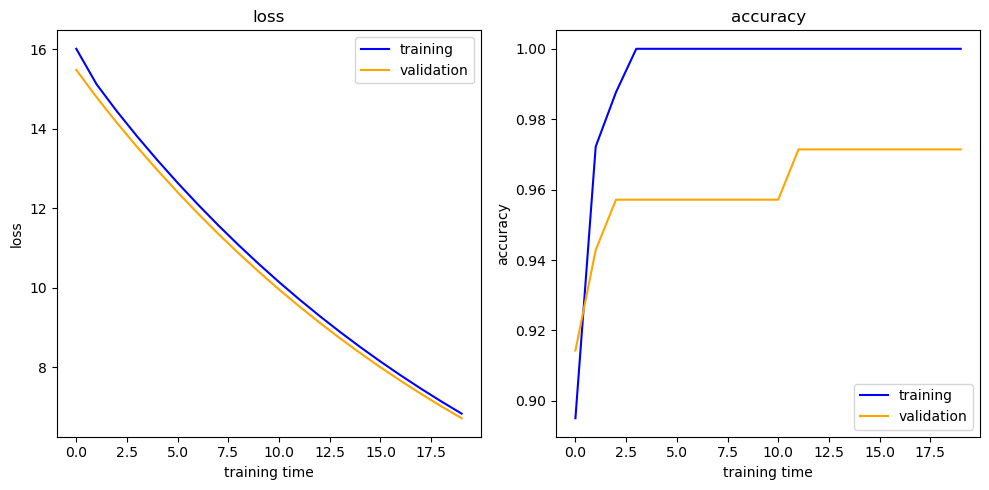

In [35]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],color='blue',label='training')
plt.plot(history.history['val_loss'],color='orange',label='validation')
plt.xlabel("training time")
plt.ylabel("loss")
plt.title("loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['categorical_accuracy'],color='blue',label='training')
plt.plot(history.history['val_categorical_accuracy'],color='orange',label='validation')
plt.xlabel("training time")
plt.ylabel("accuracy")
plt.title("accuracy")
plt.legend()

plt.tight_layout()

## Evaluate the model

### Use the trained model to predict unseen data
### Adapted from Dr. Elizabeth Barnes

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Model accuracy on test data is 100.000000%


Text(0.5, 1.0, 'Prediction on test data')

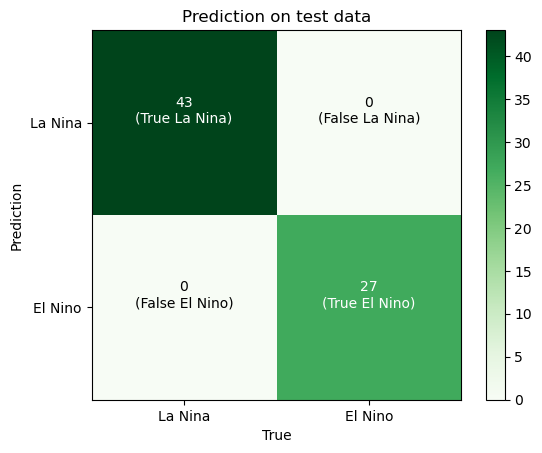

In [36]:
enso_pred = model.predict(sst_test) # make predictions for test data

enso_pred = np.argmax(enso_pred,axis=1)
enso_true = np.argmax(enso_test,axis=1)

corr_pred = enso_pred==enso_true
ncorr = corr_pred[corr_pred].shape[0]
ntest = len(enso_true)
print('Model accuracy on test data is %f%%' %(100*ncorr/ntest))

# confusion matrix
cm = tf.math.confusion_matrix(enso_true, enso_pred).numpy()
plt.imshow(cm, cmap = "Greens")
plt.text(x = 0, y = 0, s=str(cm[0,0]) + "\n(True La Nina)", color = "w", ha = "center")
plt.text(x = 0, y = 1, s=str(cm[0,1]) + "\n(False El Nino)", ha = "center")
plt.text(x = 1, y = 0, s=str(cm[1,0]) + "\n(False La Nina)", ha = "center")
plt.text(x = 1, y = 1, s=str(cm[1,1]) + "\n(True El Nino)", color = "w", ha = "center")
plt.xlabel("True")
plt.ylabel("Prediction")
plt.colorbar()
plt.xticks((0,1), labels = ["La Nina", "El Nino"])
plt.yticks((0,1), labels = ["La Nina", "El Nino"])
plt.title('Prediction on test data')